In [1]:
import ROOT
import numpy as np
import pandas as pd

if "/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/func_marti.so" not in ROOT.gSystem.GetLibraries():
    ROOT.gSystem.CompileMacro("/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/func_marti.cc","k")

if "/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/functions.so" not in ROOT.gSystem.GetLibraries():
    ROOT.gSystem.CompileMacro("/home/submit/pdmonte/CMSSW_10_6_27/src/Hrare2023/analysis/functions.cc","k")

Welcome to JupyROOT 6.28/00


In [2]:
def getNumVarsFromCode(code):
    nVars = 0
    while(code > 0):
        nVars += int(code%2)
        code = int(code/2)
    return nVars


def getTotalNumVars(modelName):
    splitted = modelName.split("_")
    numVars = getNumVarsFromCode(int(splitted[1].replace("df", "")))
    numVars += getNumVarsFromCode(int(splitted[2].replace("dl", "")))
    numVars += len(splitted) - 3
    if "opt" in modelName:
        numVars -= 1
    return numVars

In [3]:
modelName="BDTG_df15_dl3684_v0_v1_opt10329"
channel="phi"
date = "SEP25"

s = '''
    TMVA::Experimental::RReader modelScalePhi0("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_0.weights.xml");
    computeModelScalePhi0 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScalePhi0);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))
s += '''
    TMVA::Experimental::RReader modelScalePhi1("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_1.weights.xml");
    computeModelScalePhi1 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScalePhi1);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))
s += '''
    TMVA::Experimental::RReader modelScalePhi2("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_2.weights.xml");
    computeModelScalePhi2 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScalePhi2);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))

ROOT.gInterpreter.ProcessLine(s)
variables = list(ROOT.modelScalePhi0.GetVariableNames())

mesonCat = ""
mesonNum = 0
if (channel == "omega"):
    mesonCat = "OmegaCat"
    mesonNum = 1038
elif (channel == "phi"):
    mesonCat = "Phi3Cat"
    mesonNum = 1039
elif (channel == "d0starrho"):
    mesonCat = "D0StarRhoCat"
    mesonNum = 1040
elif (channel == "d0star"):
    mesonCat = "D0StarCat"
    mesonNum = 1041
else:
    raise Exception("Wrong channel.")

chainSGN0 = ROOT.TChain("events")
chainSGN1 = ROOT.TChain("events")
chainSGN2 = ROOT.TChain("events")
chainSGN0.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample0.root".format(date, mesonNum, mesonCat))
chainSGN1.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample1.root".format(date, mesonNum, mesonCat))
chainSGN2.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample2.root".format(date, mesonNum, mesonCat))

dfSGN0 = ROOT.RDataFrame(chainSGN0)
dfSGN1 = ROOT.RDataFrame(chainSGN1)
dfSGN2 = ROOT.RDataFrame(chainSGN2)

dfSGN0 = (dfSGN0.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScalePhi0, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))
dfSGN1 = (dfSGN1.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScalePhi1, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))
dfSGN2 = (dfSGN2.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScalePhi2, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))


chainBKG = ROOT.TChain("events")
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc10_GFcat_{1}_2018.root".format(date, mesonCat))
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc11_GFcat_{1}_2018.root".format(date, mesonCat))
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc12_GFcat_{1}_2018.root".format(date, mesonCat))
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc13_GFcat_{1}_2018.root".format(date, mesonCat))
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc14_GFcat_{1}_2018.root".format(date, mesonCat))

dfBKG = ROOT.RDataFrame(chainBKG)
dfBKG = (dfBKG.Define("scale", "w*lumiIntegrated")
        .Define("scaleFactor0", ROOT.computeModelScalePhi0, variables)
        .Define("scaleFactor1", ROOT.computeModelScalePhi1, variables)
        .Define("scaleFactor2", ROOT.computeModelScalePhi2, variables)
        .Define("goodMeson_pt_PRED", "(scaleFactor0[0]*goodMeson_pt[0] + scaleFactor1[0]*goodMeson_pt[0] + scaleFactor2[0]*goodMeson_pt[0])/3")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))

76994.0 19248.5
19244.0
19259.0
19432.0
19059.0


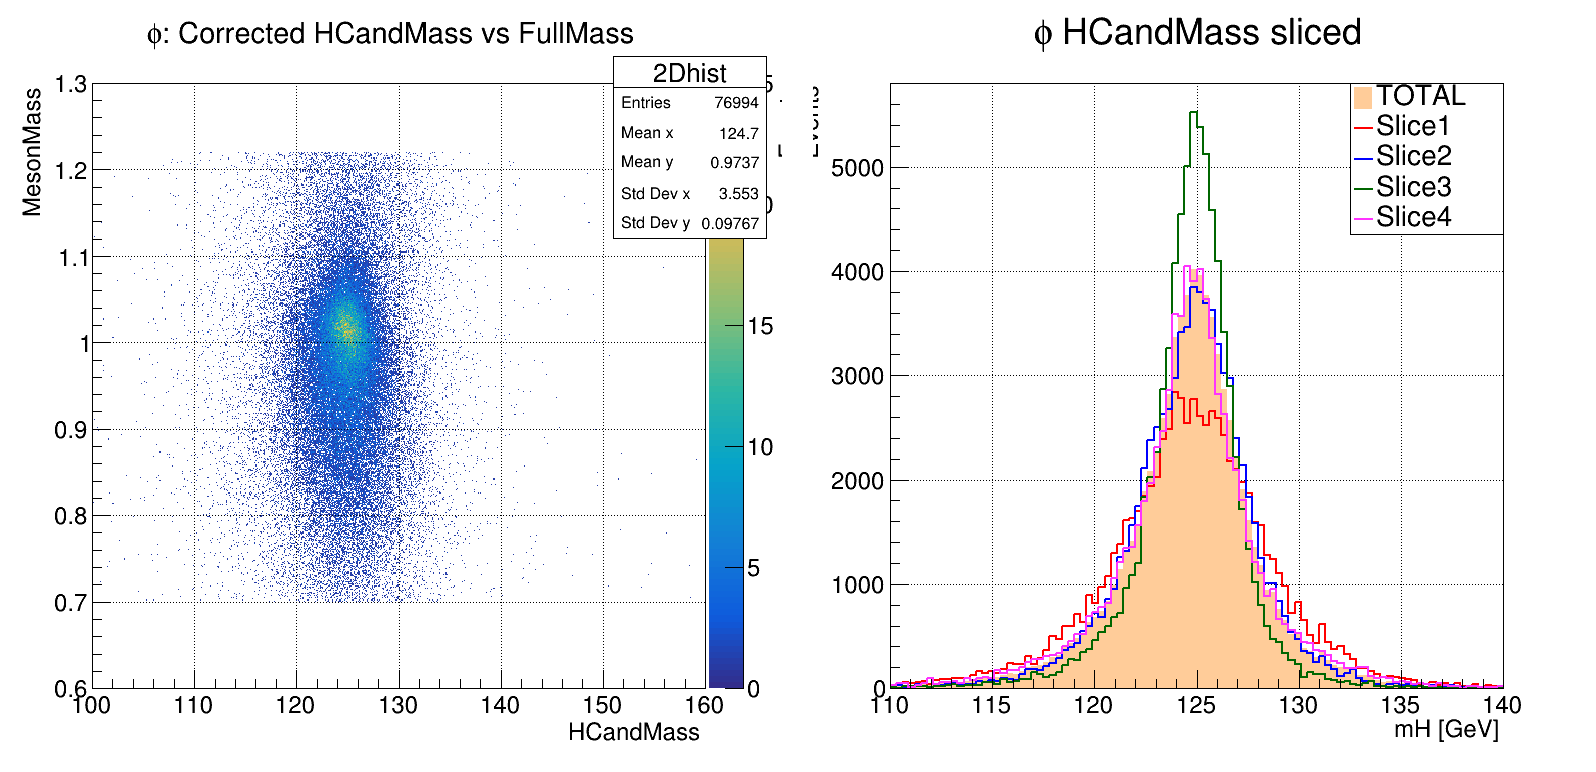

In [4]:
canvas = ROOT.TCanvas("canvas", "canvas", 1600, 800)
canvas.Divide(2, 1)

nbins, xlow, xhigh, ylow, yhigh = 600, 100, 160, 0.6, 1.3
nbinsMeson = 560
p = canvas.cd(1)
h1Pred = dfSGN0.Histo2D(("2Dhist", "#{channel}: Corrected HCandMass vs FullMass".format(channel=channel), nbins, xlow, xhigh, nbinsMeson, ylow, yhigh), "HCandMass_varPRED", "goodMeson_mass").GetValue()
h1Pred.Add(dfSGN1.Histo2D(("2Dhist", "#{channel}: Corrected HCandMass vs FullMass".format(channel=channel), nbins, xlow, xhigh, nbinsMeson, ylow, yhigh), "HCandMass_varPRED", "goodMeson_mass").GetValue())
h1Pred.Add(dfSGN2.Histo2D(("2Dhist", "#{channel}: Corrected HCandMass vs FullMass".format(channel=channel), nbins, xlow, xhigh, nbinsMeson, ylow, yhigh), "HCandMass_varPRED", "goodMeson_mass").GetValue())

h1Pred.GetXaxis().SetTitle("HCandMass")
h1Pred.GetYaxis().SetTitle("MesonMass")
h1Pred.GetZaxis().SetTitle("Events")

h1Pred.SetContour(100)
h1Pred.Draw("colz")
p.SetGrid()

p = canvas.cd(2)
nbins, xlow, xhigh = 100, 110, 140
slicingVals = [0.9174, 0.9875, 1.032]

hCandTotal = dfSGN0.Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandTotal.Add(dfSGN1.Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandTotal.Add(dfSGN2.Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandTotal.SetLineWidth(0)
hCandTotal.SetFillColor(ROOT.kOrange - 9)

hCandSlice1 = dfSGN0.Filter("goodMeson_mass[0] < {}".format(slicingVals[0])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice1.Add(dfSGN1.Filter("goodMeson_mass[0] < {}".format(slicingVals[0])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice1.Add(dfSGN2.Filter("goodMeson_mass[0] < {}".format(slicingVals[0])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice1.SetLineWidth(2)
hCandSlice1.SetLineColor(ROOT.kRed)
hCandSlice1.Scale(hCandTotal.GetEntries()/hCandSlice1.GetEntries())

hCandSlice2 = dfSGN0.Filter("goodMeson_mass[0] > {} && goodMeson_mass[0] < {}".format(slicingVals[0], slicingVals[1])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice2.Add(dfSGN1.Filter("goodMeson_mass[0] > {} && goodMeson_mass[0] < {}".format(slicingVals[0], slicingVals[1])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice2.Add(dfSGN2.Filter("goodMeson_mass[0] > {} && goodMeson_mass[0] < {}".format(slicingVals[0], slicingVals[1])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice2.SetLineWidth(2)
hCandSlice2.SetLineColor(ROOT.kBlue)
hCandSlice2.Scale(hCandTotal.GetEntries()/hCandSlice2.GetEntries())

hCandSlice3 = dfSGN0.Filter("goodMeson_mass[0] > {} && goodMeson_mass[0] < {}".format(slicingVals[1], slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice3.Add(dfSGN1.Filter("goodMeson_mass[0] > {} && goodMeson_mass[0] < {}".format(slicingVals[1], slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice3.Add(dfSGN2.Filter("goodMeson_mass[0] > {} && goodMeson_mass[0] < {}".format(slicingVals[1], slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice3.SetLineWidth(2)
hCandSlice3.SetLineColor(ROOT.kGreen + 3)
hCandSlice3.Scale(hCandTotal.GetEntries()/hCandSlice3.GetEntries())

hCandSlice4 = dfSGN0.Filter("goodMeson_mass[0] > {}".format(slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice4.Add(dfSGN1.Filter("goodMeson_mass[0] > {}".format(slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice4.Add(dfSGN2.Filter("goodMeson_mass[0] > {}".format(slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice4.SetLineWidth(2)
hCandSlice4.SetLineColor(ROOT.kMagenta - 4)
hCandSlice4.Scale(hCandTotal.GetEntries()/hCandSlice4.GetEntries())


print(hCandTotal.GetEntries(), hCandTotal.GetEntries()/4.)
print(hCandSlice1.GetEntries())
print(hCandSlice2.GetEntries())
print(hCandSlice3.GetEntries())
print(hCandSlice4.GetEntries())


stack4 = ROOT.THStack("stack", "#phi HCandMass sliced")
stack4.Add(hCandTotal)
stack4.Add(hCandSlice1)
stack4.Add(hCandSlice2)
stack4.Add(hCandSlice3)
stack4.Add(hCandSlice4)
stack4.Draw("hist nostack")
legend4 = ROOT.TLegend(0.70, 0.70, 0.9, 0.9)
legend4.SetMargin(0.17)
#legend.SetBorderSize(0)
legend4.SetTextSize(0.04)
legend4.AddEntry(hCandTotal, "TOTAL", "f")
legend4.AddEntry(hCandSlice1, "m_M < {} GeV".format(slicingVals[0]), "l")
legend4.AddEntry(hCandSlice2, "{} < m_M < {} GeV".format(slicingVals[0], slicingVals[1]), "l")
legend4.AddEntry(hCandSlice3, "{} < m_M < {} GeV".format(slicingVals[1], slicingVals[2]), "l")
legend4.AddEntry(hCandSlice4, "{} < m_M GeV".format(slicingVals[2]), "l")
legend4.Draw()
stack4.GetXaxis().SetTitle("mH [GeV]")
stack4.GetYaxis().SetTitle("Events")
p.SetGrid()

canvas.Draw()

67393.0 16848.25
25210.0
11157.0
7231.0
23795.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


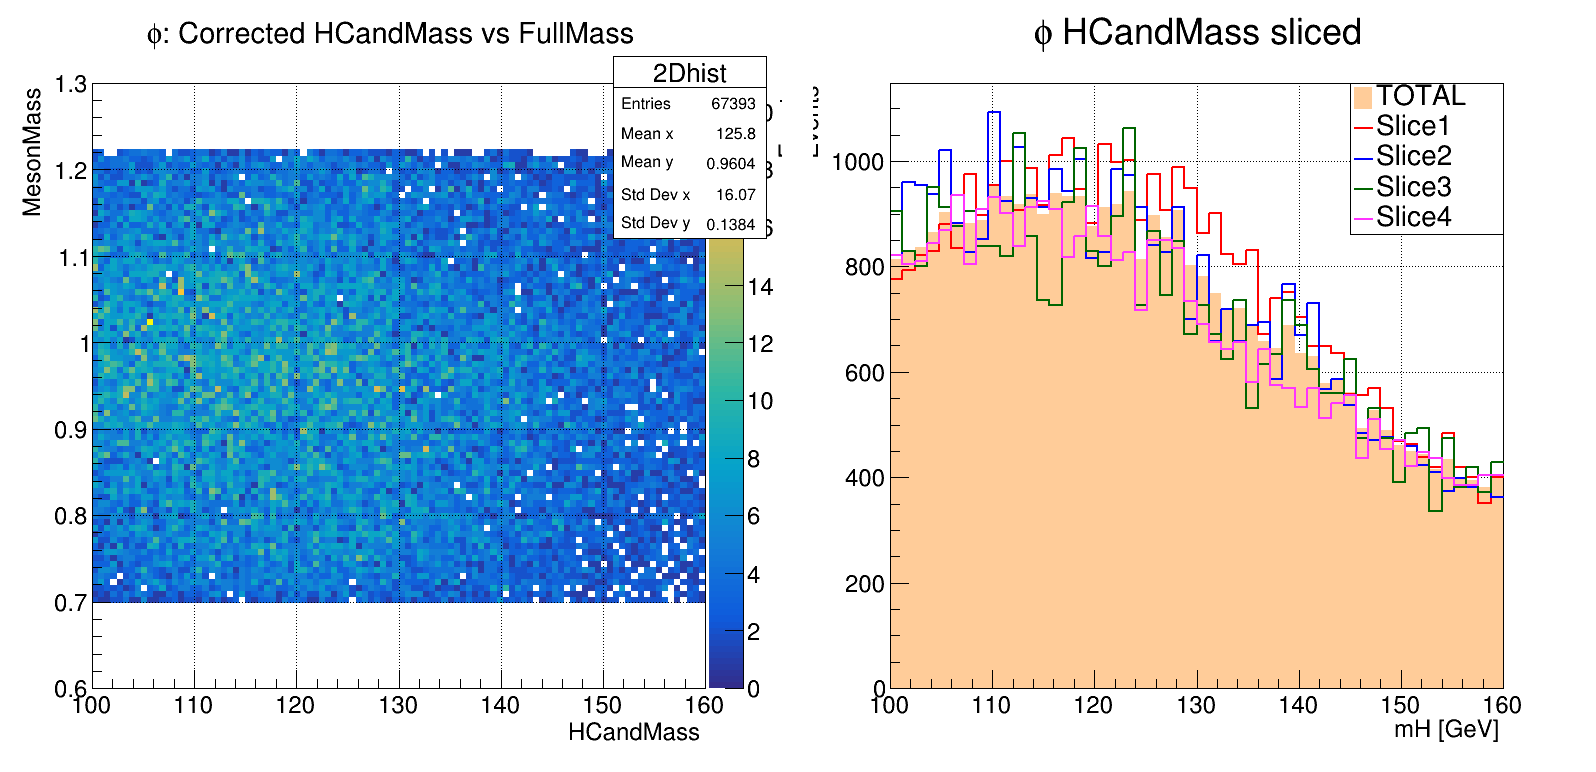

In [5]:
canvas = ROOT.TCanvas("canvas", "canvas", 1600, 800)
canvas.Divide(2, 1)

nbins, xlow, xhigh, ylow, yhigh = 100, 100, 160, 0.6, 1.3
nbinsMeson = 100
p = canvas.cd(1)
h1Pred = dfBKG.Histo2D(("2Dhist", "#{channel}: Corrected HCandMass vs FullMass".format(channel=channel), nbins, xlow, xhigh, nbinsMeson, ylow, yhigh), "HCandMass_varPRED", "goodMeson_mass").GetValue()
h1Pred.GetXaxis().SetTitle("HCandMass")
h1Pred.GetYaxis().SetTitle("MesonMass")
h1Pred.GetZaxis().SetTitle("Events")

h1Pred.SetContour(100)
h1Pred.Draw("colz")
p.SetGrid()

p = canvas.cd(2)
nbins, xlow, xhigh = 50, 100, 160
slicingVals = [0.9174, 0.9875, 1.032]

hCandTotal = dfBKG.Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandTotal.SetLineWidth(0)
hCandTotal.SetFillColor(ROOT.kOrange - 9)

hCandSlice1 = dfBKG.Filter("goodMeson_mass[0] < {}".format(slicingVals[0])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice1.SetLineWidth(2)
hCandSlice1.SetLineColor(ROOT.kRed)
hCandSlice1.Scale(hCandTotal.GetEntries()/hCandSlice1.GetEntries())

hCandSlice2 = dfBKG.Filter("goodMeson_mass[0] > {} && goodMeson_mass[0] < {}".format(slicingVals[0], slicingVals[1])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice2.SetLineWidth(2)
hCandSlice2.SetLineColor(ROOT.kBlue)
hCandSlice2.Scale(hCandTotal.GetEntries()/hCandSlice2.GetEntries())

hCandSlice3 = dfBKG.Filter("goodMeson_mass[0] > {} && goodMeson_mass[0] < {}".format(slicingVals[1], slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice3.SetLineWidth(2)
hCandSlice3.SetLineColor(ROOT.kGreen + 3)
hCandSlice3.Scale(hCandTotal.GetEntries()/hCandSlice3.GetEntries())

hCandSlice4 = dfBKG.Filter("goodMeson_mass[0] > {}".format(slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice4.SetLineWidth(2)
hCandSlice4.SetLineColor(ROOT.kMagenta - 4)
hCandSlice4.Scale(hCandTotal.GetEntries()/hCandSlice4.GetEntries())


print(hCandTotal.GetEntries(), hCandTotal.GetEntries()/4.)
print(hCandSlice1.GetEntries())
print(hCandSlice2.GetEntries())
print(hCandSlice3.GetEntries())
print(hCandSlice4.GetEntries())


stack4 = ROOT.THStack("stack", "#phi HCandMass sliced")
stack4.Add(hCandTotal)
stack4.Add(hCandSlice1)
stack4.Add(hCandSlice2)
stack4.Add(hCandSlice3)
stack4.Add(hCandSlice4)
stack4.Draw("hist nostack")
legend4 = ROOT.TLegend(0.70, 0.70, 0.9, 0.9)
legend4.SetMargin(0.17)
#legend.SetBorderSize(0)
legend4.SetTextSize(0.04)
legend4.AddEntry(hCandTotal, "TOTAL", "f")
legend4.AddEntry(hCandSlice1, "m_M < {} GeV".format(slicingVals[0]), "l")
legend4.AddEntry(hCandSlice2, "{} < m_M < {} GeV".format(slicingVals[0], slicingVals[1]), "l")
legend4.AddEntry(hCandSlice3, "{} < m_M < {} GeV".format(slicingVals[1], slicingVals[2]), "l")
legend4.AddEntry(hCandSlice4, "{} < m_M GeV".format(slicingVals[2]), "l")
legend4.Draw()
stack4.GetXaxis().SetTitle("mH [GeV]")
stack4.GetYaxis().SetTitle("Events")
p.SetGrid()

canvas.Draw()

In [6]:
modelName="BDTG_df15_dl3684_v0_v1_opt11264"
channel="omega"
date = "SEP25"

s = '''
    TMVA::Experimental::RReader modelScaleOmega0("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_0.weights.xml");
    computeModelScaleOmega0 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScaleOmega0);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))
s += '''
    TMVA::Experimental::RReader modelScaleOmega1("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_1.weights.xml");
    computeModelScaleOmega1 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScaleOmega1);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))
s += '''
    TMVA::Experimental::RReader modelScaleOmega2("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_2.weights.xml");
    computeModelScaleOmega2 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScaleOmega2);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))

ROOT.gInterpreter.ProcessLine(s)
variables = list(ROOT.modelScaleOmega0.GetVariableNames())

mesonCat = ""
mesonNum = 0
if (channel == "omega"):
    mesonCat = "OmegaCat"
    mesonNum = 1038
elif (channel == "phi"):
    mesonCat = "Phi3Cat"
    mesonNum = 1039
elif (channel == "d0starrho"):
    mesonCat = "D0StarRhoCat"
    mesonNum = 1040
elif (channel == "d0star"):
    mesonCat = "D0StarCat"
    mesonNum = 1041
else:
    raise Exception("Wrong channel.")

chainSGN0 = ROOT.TChain("events")
chainSGN1 = ROOT.TChain("events")
chainSGN2 = ROOT.TChain("events")
chainSGN0.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample0.root".format(date, mesonNum, mesonCat))
chainSGN1.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample1.root".format(date, mesonNum, mesonCat))
chainSGN2.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample2.root".format(date, mesonNum, mesonCat))

dfSGN0 = ROOT.RDataFrame(chainSGN0)
dfSGN1 = ROOT.RDataFrame(chainSGN1)
dfSGN2 = ROOT.RDataFrame(chainSGN2)

dfSGN0 = (dfSGN0.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScaleOmega0, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))
dfSGN1 = (dfSGN1.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScaleOmega1, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))
dfSGN2 = (dfSGN2.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScaleOmega2, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))

chainBKG = ROOT.TChain("events")
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc10_GFcat_{1}_2018.root".format(date, mesonCat))
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc11_GFcat_{1}_2018.root".format(date, mesonCat))
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc12_GFcat_{1}_2018.root".format(date, mesonCat))
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc13_GFcat_{1}_2018.root".format(date, mesonCat))
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc14_GFcat_{1}_2018.root".format(date, mesonCat))

dfBKG = ROOT.RDataFrame(chainBKG)
dfBKG = (dfBKG.Define("scale", "w*lumiIntegrated")
        .Define("scaleFactor0", ROOT.computeModelScaleOmega0, variables)
        .Define("scaleFactor1", ROOT.computeModelScaleOmega1, variables)
        .Define("scaleFactor2", ROOT.computeModelScaleOmega2, variables)
        .Define("goodMeson_pt_PRED", "(scaleFactor0[0]*goodMeson_pt[0] + scaleFactor1[0]*goodMeson_pt[0] + scaleFactor2[0]*goodMeson_pt[0])/3")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))

77552.0 19388.0
19987.0
18703.0
18880.0
19982.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


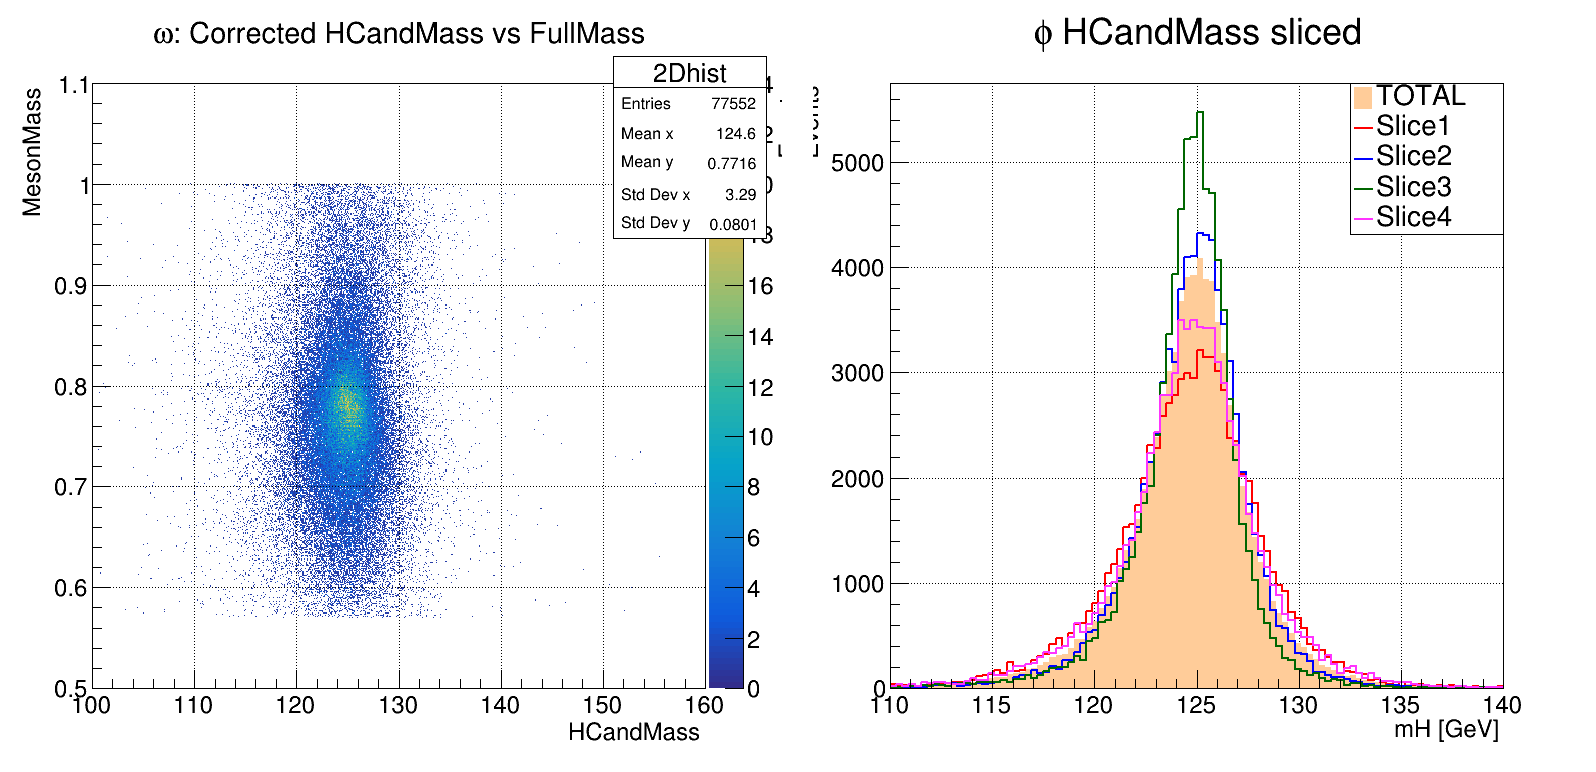

In [12]:
canvas = ROOT.TCanvas("canvas", "canvas", 1600, 800)
canvas.Divide(2, 1)

nbins, xlow, xhigh, ylow, yhigh = 600, 100, 160, 0.5, 1.1
nbinsMeson = 560
p = canvas.cd(1)
h1Pred = dfSGN0.Histo2D(("2Dhist", "#{channel}: Corrected HCandMass vs FullMass".format(channel=channel), nbins, xlow, xhigh, nbinsMeson, ylow, yhigh), "HCandMass_varPRED", "goodMeson_mass").GetValue()
h1Pred.Add(dfSGN1.Histo2D(("2Dhist", "#{channel}: Corrected HCandMass vs FullMass".format(channel=channel), nbins, xlow, xhigh, nbinsMeson, ylow, yhigh), "HCandMass_varPRED", "goodMeson_mass").GetValue())
h1Pred.Add(dfSGN2.Histo2D(("2Dhist", "#{channel}: Corrected HCandMass vs FullMass".format(channel=channel), nbins, xlow, xhigh, nbinsMeson, ylow, yhigh), "HCandMass_varPRED", "goodMeson_mass").GetValue())

h1Pred.GetXaxis().SetTitle("HCandMass")
h1Pred.GetYaxis().SetTitle("MesonMass")
h1Pred.GetZaxis().SetTitle("Events")

h1Pred.SetContour(100)
h1Pred.Draw("colz")
p.SetGrid()

p = canvas.cd(2)
nbins, xlow, xhigh = 100, 110, 140
slicingVals = [0.725, 0.77, 0.81]

hCandTotal = dfSGN0.Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandTotal.Add(dfSGN1.Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandTotal.Add(dfSGN2.Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandTotal.SetLineWidth(0)
hCandTotal.SetFillColor(ROOT.kOrange - 9)

hCandSlice1 = dfSGN0.Filter("goodMeson_mass[0] < {}".format(slicingVals[0])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice1.Add(dfSGN1.Filter("goodMeson_mass[0] < {}".format(slicingVals[0])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice1.Add(dfSGN2.Filter("goodMeson_mass[0] < {}".format(slicingVals[0])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice1.SetLineWidth(2)
hCandSlice1.SetLineColor(ROOT.kRed)
hCandSlice1.Scale(hCandTotal.GetEntries()/hCandSlice1.GetEntries())

hCandSlice2 = dfSGN0.Filter("goodMeson_mass[0] > {} && goodMeson_mass[0] < {}".format(slicingVals[0], slicingVals[1])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice2.Add(dfSGN1.Filter("goodMeson_mass[0] > {} && goodMeson_mass[0] < {}".format(slicingVals[0], slicingVals[1])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice2.Add(dfSGN2.Filter("goodMeson_mass[0] > {} && goodMeson_mass[0] < {}".format(slicingVals[0], slicingVals[1])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice2.SetLineWidth(2)
hCandSlice2.SetLineColor(ROOT.kBlue)
hCandSlice2.Scale(hCandTotal.GetEntries()/hCandSlice2.GetEntries())

hCandSlice3 = dfSGN0.Filter("goodMeson_mass[0] > {} && goodMeson_mass[0] < {}".format(slicingVals[1], slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice3.Add(dfSGN1.Filter("goodMeson_mass[0] > {} && goodMeson_mass[0] < {}".format(slicingVals[1], slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice3.Add(dfSGN2.Filter("goodMeson_mass[0] > {} && goodMeson_mass[0] < {}".format(slicingVals[1], slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice3.SetLineWidth(2)
hCandSlice3.SetLineColor(ROOT.kGreen + 3)
hCandSlice3.Scale(hCandTotal.GetEntries()/hCandSlice3.GetEntries())

hCandSlice4 = dfSGN0.Filter("goodMeson_mass[0] > {}".format(slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice4.Add(dfSGN1.Filter("goodMeson_mass[0] > {}".format(slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice4.Add(dfSGN2.Filter("goodMeson_mass[0] > {}".format(slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice4.SetLineWidth(2)
hCandSlice4.SetLineColor(ROOT.kMagenta - 4)
hCandSlice4.Scale(hCandTotal.GetEntries()/hCandSlice4.GetEntries())


print(hCandTotal.GetEntries(), hCandTotal.GetEntries()/4.)
print(hCandSlice1.GetEntries())
print(hCandSlice2.GetEntries())
print(hCandSlice3.GetEntries())
print(hCandSlice4.GetEntries())


stack4 = ROOT.THStack("stack", "#phi HCandMass sliced")
stack4.Add(hCandTotal)
stack4.Add(hCandSlice1)
stack4.Add(hCandSlice2)
stack4.Add(hCandSlice3)
stack4.Add(hCandSlice4)
stack4.Draw("hist nostack")
legend4 = ROOT.TLegend(0.70, 0.70, 0.9, 0.9)
legend4.SetMargin(0.17)
#legend.SetBorderSize(0)
legend4.SetTextSize(0.04)
legend4.AddEntry(hCandTotal, "TOTAL", "f")
legend4.AddEntry(hCandSlice1, "m_M < {} GeV".format(slicingVals[0]), "l")
legend4.AddEntry(hCandSlice2, "{} < m_M < {} GeV".format(slicingVals[0], slicingVals[1]), "l")
legend4.AddEntry(hCandSlice3, "{} < m_M < {} GeV".format(slicingVals[1], slicingVals[2]), "l")
legend4.AddEntry(hCandSlice4, "{} < m_M GeV".format(slicingVals[2]), "l")
legend4.Draw()
stack4.GetXaxis().SetTitle("mH [GeV]")
stack4.GetYaxis().SetTitle("Events")
p.SetGrid()

canvas.Draw()

29181.0 7295.25
6985.0
3822.0
3638.0
14736.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


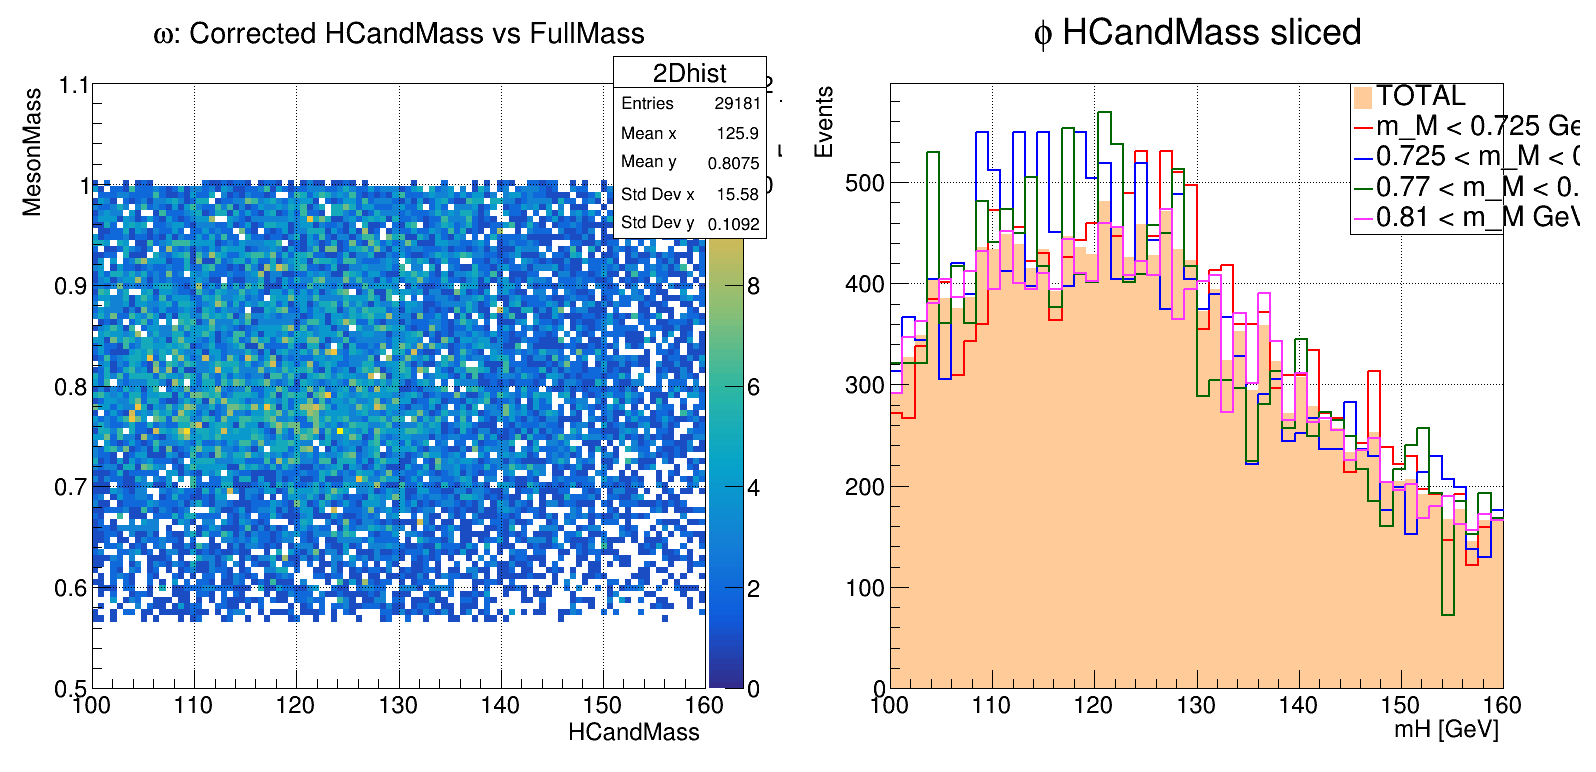

In [13]:
canvas = ROOT.TCanvas("canvas", "canvas", 1600, 800)
canvas.Divide(2, 1)

nbins, xlow, xhigh, ylow, yhigh = 100, 100, 160, 0.5, 1.1
nbinsMeson = 100
p = canvas.cd(1)
h1Pred = dfBKG.Histo2D(("2Dhist", "#{channel}: Corrected HCandMass vs FullMass".format(channel=channel), nbins, xlow, xhigh, nbinsMeson, ylow, yhigh), "HCandMass_varPRED", "goodMeson_mass").GetValue()
h1Pred.GetXaxis().SetTitle("HCandMass")
h1Pred.GetYaxis().SetTitle("MesonMass")
h1Pred.GetZaxis().SetTitle("Events")

h1Pred.SetContour(100)
h1Pred.Draw("colz")
p.SetGrid()

p = canvas.cd(2)
nbins, xlow, xhigh = 50, 100, 160
slicingVals = [0.725, 0.77, 0.81]

hCandTotal = dfBKG.Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandTotal.SetLineWidth(0)
hCandTotal.SetFillColor(ROOT.kOrange - 9)

hCandSlice1 = dfBKG.Filter("goodMeson_mass[0] < {}".format(slicingVals[0])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice1.SetLineWidth(2)
hCandSlice1.SetLineColor(ROOT.kRed)
hCandSlice1.Scale(hCandTotal.GetEntries()/hCandSlice1.GetEntries())

hCandSlice2 = dfBKG.Filter("goodMeson_mass[0] > {} && goodMeson_mass[0] < {}".format(slicingVals[0], slicingVals[1])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice2.SetLineWidth(2)
hCandSlice2.SetLineColor(ROOT.kBlue)
hCandSlice2.Scale(hCandTotal.GetEntries()/hCandSlice2.GetEntries())

hCandSlice3 = dfBKG.Filter("goodMeson_mass[0] > {} && goodMeson_mass[0] < {}".format(slicingVals[1], slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice3.SetLineWidth(2)
hCandSlice3.SetLineColor(ROOT.kGreen + 3)
hCandSlice3.Scale(hCandTotal.GetEntries()/hCandSlice3.GetEntries())

hCandSlice4 = dfBKG.Filter("goodMeson_mass[0] > {}".format(slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice4.SetLineWidth(2)
hCandSlice4.SetLineColor(ROOT.kMagenta - 4)
hCandSlice4.Scale(hCandTotal.GetEntries()/hCandSlice4.GetEntries())


print(hCandTotal.GetEntries(), hCandTotal.GetEntries()/4.)
print(hCandSlice1.GetEntries())
print(hCandSlice2.GetEntries())
print(hCandSlice3.GetEntries())
print(hCandSlice4.GetEntries())


stack4 = ROOT.THStack("stack", "#phi HCandMass sliced")
stack4.Add(hCandTotal)
stack4.Add(hCandSlice1)
stack4.Add(hCandSlice2)
stack4.Add(hCandSlice3)
stack4.Add(hCandSlice4)
stack4.Draw("hist nostack")
legend4 = ROOT.TLegend(0.70, 0.70, 0.9, 0.9)
legend4.SetMargin(0.17)
#legend.SetBorderSize(0)
legend4.SetTextSize(0.04)
legend4.AddEntry(hCandTotal, "TOTAL", "f")
legend4.AddEntry(hCandSlice1, "m_M < {} GeV".format(slicingVals[0]), "l")
legend4.AddEntry(hCandSlice2, "{} < m_M < {} GeV".format(slicingVals[0], slicingVals[1]), "l")
legend4.AddEntry(hCandSlice3, "{} < m_M < {} GeV".format(slicingVals[1], slicingVals[2]), "l")
legend4.AddEntry(hCandSlice4, "{} < m_M GeV".format(slicingVals[2]), "l")
legend4.Draw()
stack4.GetXaxis().SetTitle("mH [GeV]")
stack4.GetYaxis().SetTitle("Events")
p.SetGrid()

canvas.Draw()

In [3]:
modelName="BDTG_df7_dl3684_v0_v1_opt12167"
channel="d0star"
date = "SEP25"

s = '''
    TMVA::Experimental::RReader modelScaleD0Star0("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_0.weights.xml");
    computeModelScaleD0Star0 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScaleD0Star0);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))
s += '''
    TMVA::Experimental::RReader modelScaleD0Star1("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_1.weights.xml");
    computeModelScaleD0Star1 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScaleD0Star1);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))
s += '''
    TMVA::Experimental::RReader modelScaleD0Star2("/data/submit/pdmonte/TMVA_models/weightsOpts2/TMVARegression_{modelName}_{channel}_2.weights.xml");
    computeModelScaleD0Star2 = TMVA::Experimental::Compute<{numVarsTotal}, float>(modelScaleD0Star2);
    '''.format(modelName=modelName, channel=channel, numVarsTotal=getTotalNumVars(modelName))

ROOT.gInterpreter.ProcessLine(s)
variables = list(ROOT.modelScaleD0Star0.GetVariableNames())

mesonCat = ""
mesonNum = 0
if (channel == "omega"):
    mesonCat = "OmegaCat"
    mesonNum = 1038
elif (channel == "phi"):
    mesonCat = "Phi3Cat"
    mesonNum = 1039
elif (channel == "d0starrho"):
    mesonCat = "D0StarRhoCat"
    mesonNum = 1040
elif (channel == "d0star"):
    mesonCat = "D0StarCat"
    mesonNum = 1041
else:
    raise Exception("Wrong channel.")

chainSGN0 = ROOT.TChain("events")
chainSGN1 = ROOT.TChain("events")
chainSGN2 = ROOT.TChain("events")
chainSGN0.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample0.root".format(date, mesonNum, mesonCat))
chainSGN1.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample1.root".format(date, mesonNum, mesonCat))
chainSGN2.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc{1}_GFcat_{2}_2018_sample2.root".format(date, mesonNum, mesonCat))

dfSGN0 = ROOT.RDataFrame(chainSGN0)
dfSGN1 = ROOT.RDataFrame(chainSGN1)
dfSGN2 = ROOT.RDataFrame(chainSGN2)

dfSGN0 = (dfSGN0.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScaleD0Star0, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))
dfSGN1 = (dfSGN1.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScaleD0Star1, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))
dfSGN2 = (dfSGN2.Define("scale", "w*lumiIntegrated/3.")
        .Define("HCandMass_GEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta_GEN, goodMeson_phi_GEN, goodMeson_mass_GEN, goodPhotons_pt_GEN, goodPhotons_eta_GEN, goodPhotons_phi_GEN, 0)")
        .Define("HCandMass_varGEN", "compute_HiggsVars_var(goodMeson_pt_GEN, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)")
        .Define("scaleFactor", ROOT.computeModelScaleD0Star2, variables)
        .Define("goodMeson_pt_PRED", "scaleFactor[0]*goodMeson_pt[0]")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))

chainBKG = ROOT.TChain("events")
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc10_GFcat_{1}_2018.root".format(date, mesonCat))
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc11_GFcat_{1}_2018.root".format(date, mesonCat))
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc12_GFcat_{1}_2018.root".format(date, mesonCat))
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc13_GFcat_{1}_2018.root".format(date, mesonCat))
chainBKG.Add("/data/submit/pdmonte/outputs/{0}/2018/outname_mc14_GFcat_{1}_2018.root".format(date, mesonCat))

dfBKG = ROOT.RDataFrame(chainBKG)
dfBKG = (dfBKG.Define("scale", "w*lumiIntegrated")
        .Define("scaleFactor0", ROOT.computeModelScaleD0Star0, variables)
        .Define("scaleFactor1", ROOT.computeModelScaleD0Star1, variables)
        .Define("scaleFactor2", ROOT.computeModelScaleD0Star2, variables)
        .Define("goodMeson_pt_PRED", "(scaleFactor0[0]*goodMeson_pt[0] + scaleFactor1[0]*goodMeson_pt[0] + scaleFactor2[0]*goodMeson_pt[0])/3")
        .Define("HCandMass_varPRED", "compute_HiggsVars_var(goodMeson_pt_PRED, goodMeson_eta[0], goodMeson_phi[0], goodMeson_mass[0], goodPhotons_pt[0], goodPhotons_eta[0], goodPhotons_phi[0], 0)"))

88995.0 22248.75
22450.0
22532.0
22078.0
21935.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


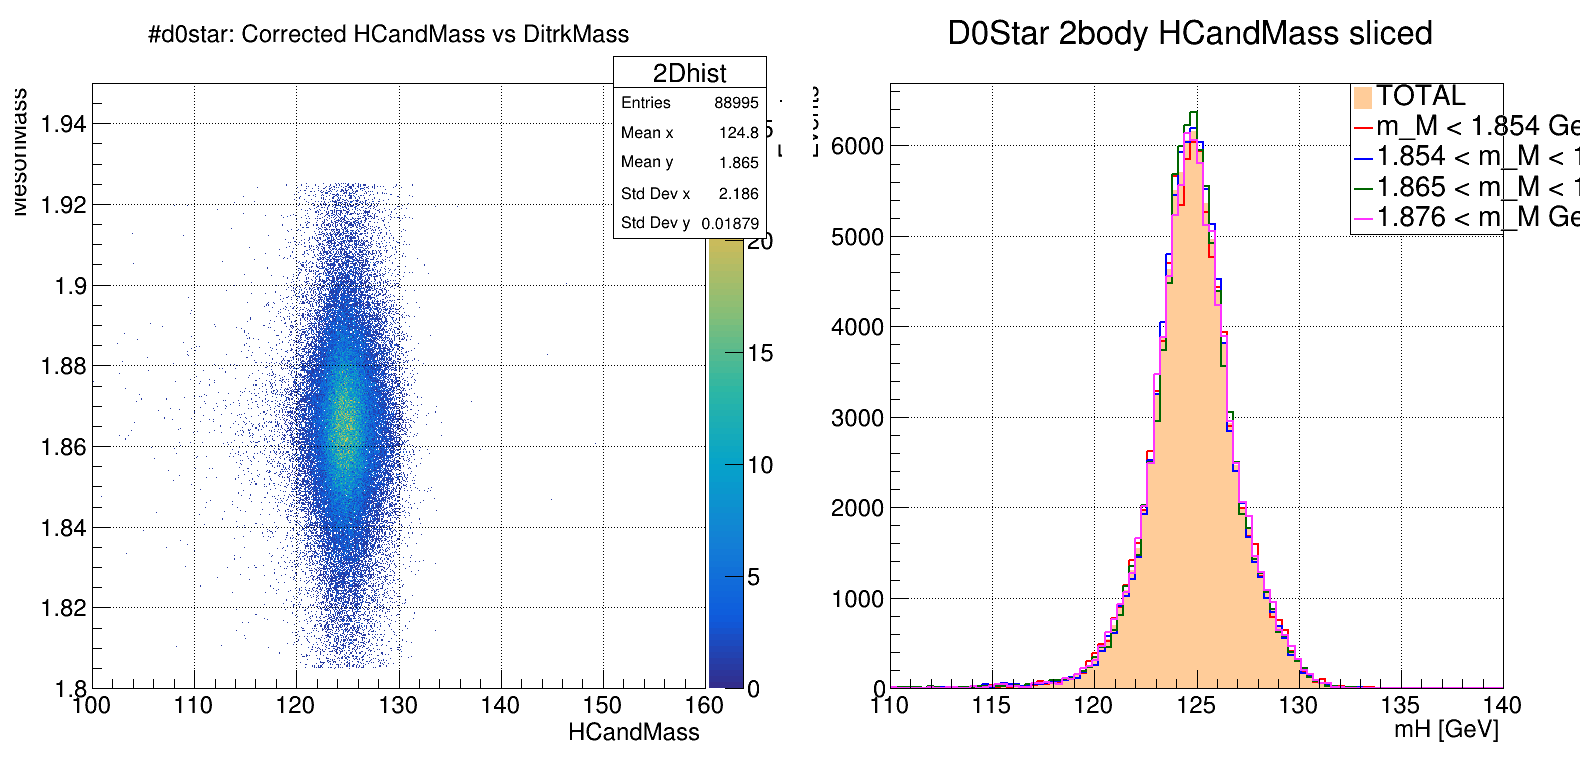

In [6]:
canvas = ROOT.TCanvas("canvas", "canvas", 1600, 800)
canvas.Divide(2, 1)

nbins, xlow, xhigh, ylow, yhigh = 600, 100, 160, 1.8, 1.95
nbinsMeson = 560
p = canvas.cd(1)
h1Pred = dfSGN0.Histo2D(("2Dhist", "#{channel}: Corrected HCandMass vs DitrkMass".format(channel=channel), nbins, xlow, xhigh, nbinsMeson, ylow, yhigh), "HCandMass_varPRED", "goodMeson_ditrk_mass").GetValue()
h1Pred.Add(dfSGN1.Histo2D(("2Dhist", "#{channel}: Corrected HCandMass vs DitrkMass".format(channel=channel), nbins, xlow, xhigh, nbinsMeson, ylow, yhigh), "HCandMass_varPRED", "goodMeson_ditrk_mass").GetValue())
h1Pred.Add(dfSGN2.Histo2D(("2Dhist", "#{channel}: Corrected HCandMass vs DitrkMass".format(channel=channel), nbins, xlow, xhigh, nbinsMeson, ylow, yhigh), "HCandMass_varPRED", "goodMeson_ditrk_mass").GetValue())

h1Pred.GetXaxis().SetTitle("HCandMass")
h1Pred.GetYaxis().SetTitle("MesonMass")
h1Pred.GetZaxis().SetTitle("Events")

h1Pred.SetContour(100)
h1Pred.Draw("colz")
p.SetGrid()

p = canvas.cd(2)
nbins, xlow, xhigh = 100, 110, 140
slicingVals = [1.854, 1.865, 1.876]

hCandTotal = dfSGN0.Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandTotal.Add(dfSGN1.Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandTotal.Add(dfSGN2.Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandTotal.SetLineWidth(0)
hCandTotal.SetFillColor(ROOT.kOrange - 9)

hCandSlice1 = dfSGN0.Filter("goodMeson_ditrk_mass[0] < {}".format(slicingVals[0])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice1.Add(dfSGN1.Filter("goodMeson_ditrk_mass[0] < {}".format(slicingVals[0])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice1.Add(dfSGN2.Filter("goodMeson_ditrk_mass[0] < {}".format(slicingVals[0])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice1.SetLineWidth(2)
hCandSlice1.SetLineColor(ROOT.kRed)
hCandSlice1.Scale(hCandTotal.GetEntries()/hCandSlice1.GetEntries())

hCandSlice2 = dfSGN0.Filter("goodMeson_ditrk_mass[0] > {} && goodMeson_ditrk_mass[0] < {}".format(slicingVals[0], slicingVals[1])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice2.Add(dfSGN1.Filter("goodMeson_ditrk_mass[0] > {} && goodMeson_ditrk_mass[0] < {}".format(slicingVals[0], slicingVals[1])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice2.Add(dfSGN2.Filter("goodMeson_ditrk_mass[0] > {} && goodMeson_ditrk_mass[0] < {}".format(slicingVals[0], slicingVals[1])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice2.SetLineWidth(2)
hCandSlice2.SetLineColor(ROOT.kBlue)
hCandSlice2.Scale(hCandTotal.GetEntries()/hCandSlice2.GetEntries())

hCandSlice3 = dfSGN0.Filter("goodMeson_ditrk_mass[0] > {} && goodMeson_ditrk_mass[0] < {}".format(slicingVals[1], slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice3.Add(dfSGN1.Filter("goodMeson_ditrk_mass[0] > {} && goodMeson_ditrk_mass[0] < {}".format(slicingVals[1], slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice3.Add(dfSGN2.Filter("goodMeson_ditrk_mass[0] > {} && goodMeson_ditrk_mass[0] < {}".format(slicingVals[1], slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice3.SetLineWidth(2)
hCandSlice3.SetLineColor(ROOT.kGreen + 3)
hCandSlice3.Scale(hCandTotal.GetEntries()/hCandSlice3.GetEntries())

hCandSlice4 = dfSGN0.Filter("goodMeson_ditrk_mass[0] > {}".format(slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice4.Add(dfSGN1.Filter("goodMeson_ditrk_mass[0] > {}".format(slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice4.Add(dfSGN2.Filter("goodMeson_ditrk_mass[0] > {}".format(slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue())
hCandSlice4.SetLineWidth(2)
hCandSlice4.SetLineColor(ROOT.kMagenta - 4)
hCandSlice4.Scale(hCandTotal.GetEntries()/hCandSlice4.GetEntries())


print(hCandTotal.GetEntries(), hCandTotal.GetEntries()/4.)
print(hCandSlice1.GetEntries())
print(hCandSlice2.GetEntries())
print(hCandSlice3.GetEntries())
print(hCandSlice4.GetEntries())


stack4 = ROOT.THStack("stack", "D0Star 2body HCandMass sliced")
stack4.Add(hCandTotal)
stack4.Add(hCandSlice1)
stack4.Add(hCandSlice2)
stack4.Add(hCandSlice3)
stack4.Add(hCandSlice4)
stack4.Draw("hist nostack")
legend4 = ROOT.TLegend(0.70, 0.70, 0.9, 0.9)
legend4.SetMargin(0.17)
#legend.SetBorderSize(0)
legend4.SetTextSize(0.04)
legend4.AddEntry(hCandTotal, "TOTAL", "f")
legend4.AddEntry(hCandSlice1, "m_M < {} GeV".format(slicingVals[0]), "l")
legend4.AddEntry(hCandSlice2, "{} < m_M < {} GeV".format(slicingVals[0], slicingVals[1]), "l")
legend4.AddEntry(hCandSlice3, "{} < m_M < {} GeV".format(slicingVals[1], slicingVals[2]), "l")
legend4.AddEntry(hCandSlice4, "{} < m_M GeV".format(slicingVals[2]), "l")
legend4.Draw()
stack4.GetXaxis().SetTitle("mH [GeV]")
stack4.GetYaxis().SetTitle("Events")
p.SetGrid()

canvas.Draw()

4457.0 1114.25
1902.0
459.0
504.0
1592.0


Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas


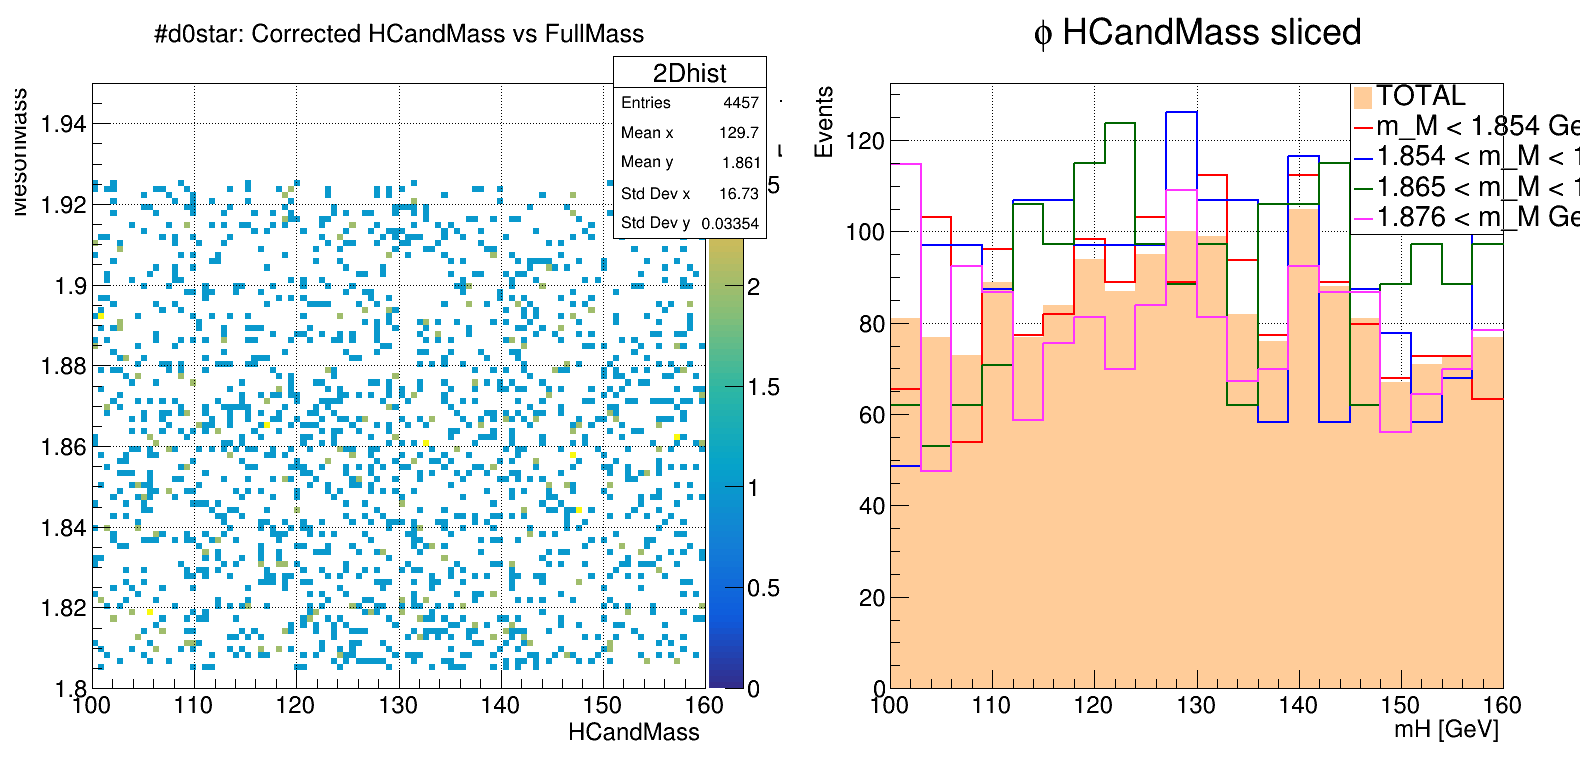

In [8]:
canvas = ROOT.TCanvas("canvas", "canvas", 1600, 800)
canvas.Divide(2, 1)

nbins, xlow, xhigh, ylow, yhigh = 100, 100, 160, 1.8, 1.95
nbinsMeson = 100
p = canvas.cd(1)
h1Pred = dfBKG.Histo2D(("2Dhist", "#{channel}: Corrected HCandMass vs FullMass".format(channel=channel), nbins, xlow, xhigh, nbinsMeson, ylow, yhigh), "HCandMass_varPRED", "goodMeson_ditrk_mass").GetValue()
h1Pred.GetXaxis().SetTitle("HCandMass")
h1Pred.GetYaxis().SetTitle("MesonMass")
h1Pred.GetZaxis().SetTitle("Events")

h1Pred.SetContour(100)
h1Pred.Draw("colz")
p.SetGrid()

p = canvas.cd(2)
nbins, xlow, xhigh = 20, 100, 160
slicingVals = [1.854, 1.865, 1.876]

hCandTotal = dfBKG.Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandTotal.SetLineWidth(0)
hCandTotal.SetFillColor(ROOT.kOrange - 9)

hCandSlice1 = dfBKG.Filter("goodMeson_ditrk_mass[0] < {}".format(slicingVals[0])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice1.SetLineWidth(2)
hCandSlice1.SetLineColor(ROOT.kRed)
hCandSlice1.Scale(hCandTotal.GetEntries()/hCandSlice1.GetEntries())

hCandSlice2 = dfBKG.Filter("goodMeson_ditrk_mass[0] > {} && goodMeson_ditrk_mass[0] < {}".format(slicingVals[0], slicingVals[1])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice2.SetLineWidth(2)
hCandSlice2.SetLineColor(ROOT.kBlue)
hCandSlice2.Scale(hCandTotal.GetEntries()/hCandSlice2.GetEntries())

hCandSlice3 = dfBKG.Filter("goodMeson_ditrk_mass[0] > {} && goodMeson_ditrk_mass[0] < {}".format(slicingVals[1], slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice3.SetLineWidth(2)
hCandSlice3.SetLineColor(ROOT.kGreen + 3)
hCandSlice3.Scale(hCandTotal.GetEntries()/hCandSlice3.GetEntries())

hCandSlice4 = dfBKG.Filter("goodMeson_ditrk_mass[0] > {}".format(slicingVals[2])).Histo1D(("1Dhist", "{channel}: HCandMass".format(channel=channel), nbins, xlow, xhigh), "HCandMass_varPRED").GetValue()
hCandSlice4.SetLineWidth(2)
hCandSlice4.SetLineColor(ROOT.kMagenta - 4)
hCandSlice4.Scale(hCandTotal.GetEntries()/hCandSlice4.GetEntries())


print(hCandTotal.GetEntries(), hCandTotal.GetEntries()/4.)
print(hCandSlice1.GetEntries())
print(hCandSlice2.GetEntries())
print(hCandSlice3.GetEntries())
print(hCandSlice4.GetEntries())


stack4 = ROOT.THStack("stack", "#phi HCandMass sliced")
stack4.Add(hCandTotal)
stack4.Add(hCandSlice1)
stack4.Add(hCandSlice2)
stack4.Add(hCandSlice3)
stack4.Add(hCandSlice4)
stack4.Draw("hist nostack")
legend4 = ROOT.TLegend(0.70, 0.70, 0.9, 0.9)
legend4.SetMargin(0.17)
#legend.SetBorderSize(0)
legend4.SetTextSize(0.04)
legend4.AddEntry(hCandTotal, "TOTAL", "f")
legend4.AddEntry(hCandSlice1, "m_M < {} GeV".format(slicingVals[0]), "l")
legend4.AddEntry(hCandSlice2, "{} < m_M < {} GeV".format(slicingVals[0], slicingVals[1]), "l")
legend4.AddEntry(hCandSlice3, "{} < m_M < {} GeV".format(slicingVals[1], slicingVals[2]), "l")
legend4.AddEntry(hCandSlice4, "{} < m_M GeV".format(slicingVals[2]), "l")
legend4.Draw()
stack4.GetXaxis().SetTitle("mH [GeV]")
stack4.GetYaxis().SetTitle("Events")
p.SetGrid()

canvas.Draw()